Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular,Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
import matplotlib.pyplot as plt

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
def decorrelate(num_epochs, data, model, lr=1e-2):

    # covariance matrix before training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    L = np.zeros(num_epochs)
    for i in range(num_epochs):
        y = model.forward(data)
        L[i] = model.update()
        model.R -= lr * model.R.grad
        print(f'iteration {i}\tloss: {L[i]:.3f}')

    # covariance matrix after training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return L, A1, A2

We start by showing effective decorrelation of correlated input

iteration 0	loss: 0.037
iteration 1	loss: 0.025
iteration 2	loss: 0.018
iteration 3	loss: 0.014
iteration 4	loss: 0.011
iteration 5	loss: 0.009
iteration 6	loss: 0.007
iteration 7	loss: 0.006
iteration 8	loss: 0.005
iteration 9	loss: 0.005
iteration 10	loss: 0.004
iteration 11	loss: 0.004
iteration 12	loss: 0.003
iteration 13	loss: 0.003
iteration 14	loss: 0.003
iteration 15	loss: 0.002
iteration 16	loss: 0.002
iteration 17	loss: 0.002
iteration 18	loss: 0.002
iteration 19	loss: 0.002
iteration 20	loss: 0.002
iteration 21	loss: 0.002
iteration 22	loss: 0.001
iteration 23	loss: 0.001
iteration 24	loss: 0.001
iteration 25	loss: 0.001
iteration 26	loss: 0.001
iteration 27	loss: 0.001
iteration 28	loss: 0.001
iteration 29	loss: 0.001
iteration 30	loss: 0.001
iteration 31	loss: 0.001
iteration 32	loss: 0.001
iteration 33	loss: 0.001
iteration 34	loss: 0.001
iteration 35	loss: 0.001
iteration 36	loss: 0.001
iteration 37	loss: 0.001
iteration 38	loss: 0.001
iteration 39	loss: 0.001
iteration 

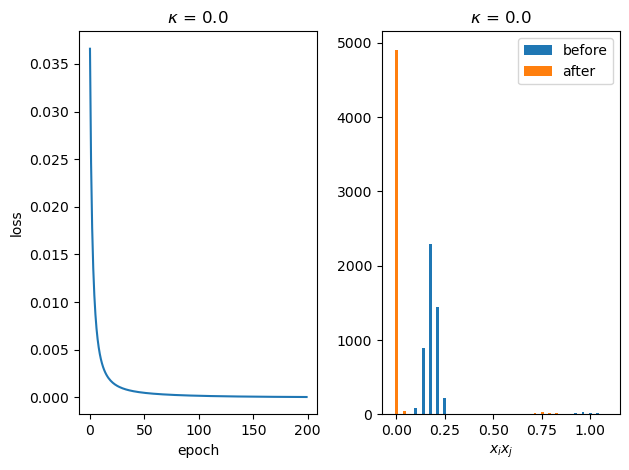

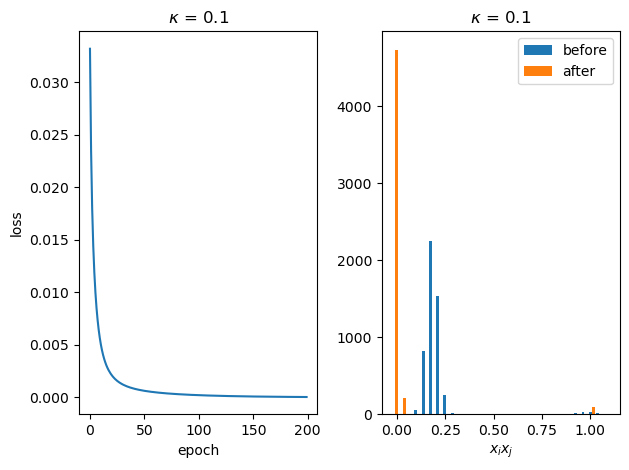

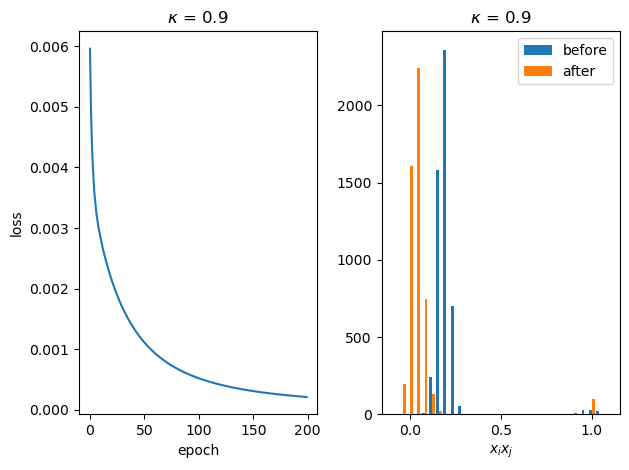

In [7]:
num_samples=1000
num_features=100
num_epochs=200
kappas = [0.0, 0.1, 0.9]
# ensure that we are at the same scale of the original lr
orig_lr=1e-2
lr = orig_lr * (num_features *  (num_features-1)) / 4

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,))

for kappa in kappas:

    # create a decorrelator
    model = Decorrelation(dim=num_features, kappa=kappa)

    L, A1, A2 = decorrelate(num_epochs, data, model, lr=lr) 

    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(L)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(f'$\kappa$ = {kappa}')
    plt.subplot(1,2,2)
    plt.hist([lower_triangular(A1, offset=0), lower_triangular(A2, offset=0)], bins=30, label=['before', 'after'])
    plt.legend()
    plt.xlabel('$x_i x_j$')
    plt.title(f'$\kappa$ = {kappa}')
    plt.legend();
    plt.tight_layout()

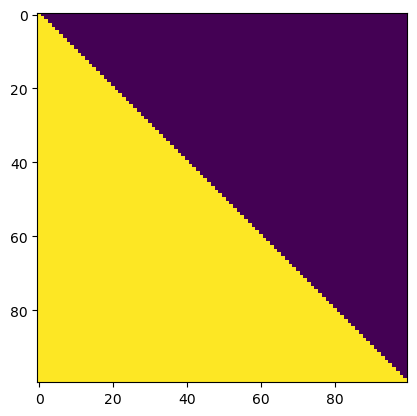

In [4]:
# we learn a lower triangular matrix
plt.imshow(model.R.detach().numpy() != 0);

Decorrelation of correlated input using DecorConv2d

iteration 0	loss: 0.956
iteration 1	loss: 0.455
iteration 2	loss: 0.356
iteration 3	loss: 0.344
iteration 4	loss: 0.176
iteration 5	loss: 0.234
iteration 6	loss: 0.126
iteration 7	loss: 0.163
iteration 8	loss: 0.207
iteration 9	loss: 0.117
iteration 10	loss: 0.115
iteration 11	loss: 0.092
iteration 12	loss: 0.072
iteration 13	loss: 0.065
iteration 14	loss: 0.077
iteration 15	loss: 0.060
iteration 16	loss: 0.080
iteration 17	loss: 0.052
iteration 18	loss: 0.058
iteration 19	loss: 0.041
iteration 20	loss: 0.053
iteration 21	loss: 0.031
iteration 22	loss: 0.036
iteration 23	loss: 0.063
iteration 24	loss: 0.031
iteration 25	loss: 0.039
iteration 26	loss: 0.018
iteration 27	loss: 0.029
iteration 28	loss: 0.029
iteration 29	loss: 0.016
iteration 30	loss: 0.026
iteration 31	loss: 0.024
iteration 32	loss: 0.026
iteration 33	loss: 0.016
iteration 34	loss: 0.023
iteration 35	loss: 0.011
iteration 36	loss: 0.022
iteration 37	loss: 0.014
iteration 38	loss: 0.022
iteration 39	loss: 0.014
iteration 

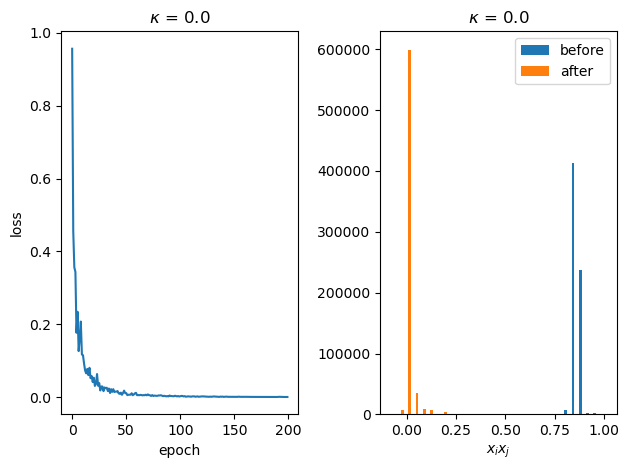

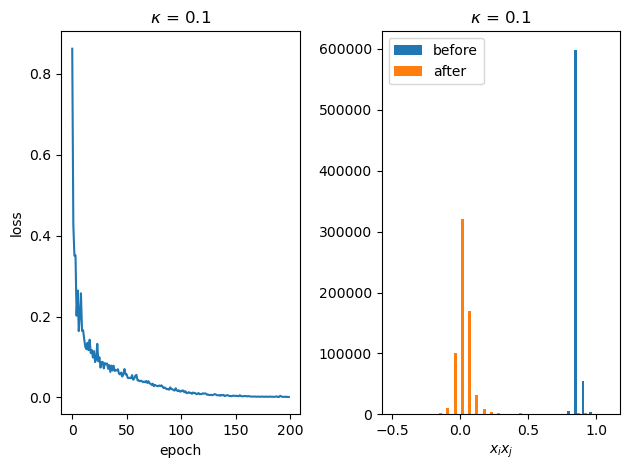

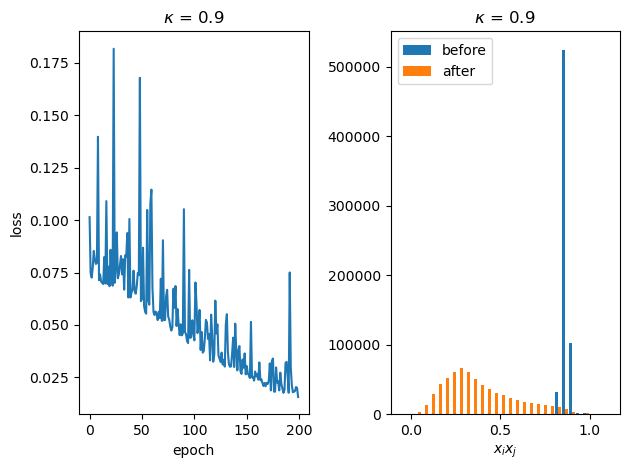

In [5]:
# generate [N, M] correlated input
num_examples=1000
in_channels=2
out_channels=3
height=10
width=10
kernel_size=(3,3)
num_samples=1000
num_epochs=200
kappas = [0.0, 0.1, 0.9]
seed = 42
downsample_perc=0.1

num_features=in_channels*height*width
size = in_channels * np.prod(kernel_size)

# ensure that we are at the same scale of the original lr
orig_lr=1e-2 # If we decrease lr (e.g. 1e-3) then things become less stable...?
lr = orig_lr * (size *  (size-1)) / 4

for kappa in kappas:

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
    data = d.sample((num_examples,)).reshape(num_examples,in_channels,height,width)

    # create a convolutional decorrelator
    model = DecorConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, kappa=kappa, downsample_perc=downsample_perc)

    L, A1, A2 = decorrelate(num_epochs, data, model, lr=lr) 

    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(L)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(f'$\kappa$ = {kappa}')
    plt.subplot(1,2,2)
    plt.hist([lower_triangular(A1, offset=0), lower_triangular(A2, offset=0)], bins=30, label=['before', 'after'])
    plt.legend()
    plt.xlabel('$x_i x_j$')
    plt.title(f'$\kappa$ = {kappa}')
    plt.legend();
    plt.tight_layout()

In [6]:
# WHEN IT WORKS WE CAN START TO COMBINE WITH A PATCHWISE MODEL

To do:
- experiment can be used if current approach works. Do we have any guarantee of decorrelated input if average over patches? and if we take only center pixel? We can check by extracting the patches for the created output again and compute covariances
- reimplement code sander as starting point also for comparison